# Phase 0: EDA 

### Basic Overview

In [1]:
import pandas as pd

df = pd.read_csv("./data/beijing.csv")

# Basic info
print("Shape: ", df.shape)
print("Dtypes:\n",df.dtypes)
print(df.head())

# Quick stats
print(df.describe())


Shape:  (39523, 20)
Dtypes:
 year             int64
month            int64
day              int64
hour             int64
zone             int64
city            object
longitude      float64
latitude       float64
aqi              int64
co             float64
no             float64
no2            float64
o3             float64
so2            float64
pm2_5          float64
pm10           float64
nh3            float64
temperature    float64
dewpt          float64
date            object
dtype: object
   year  month  day  hour  zone     city  longitude  latitude  aqi       co  \
0  2020     11   25     1    46  Beijing   116.3913   39.9062    5  3952.03   
1  2020     11   25     2    46  Beijing   116.3913   39.9062    5  3417.97   
2  2020     11   25     3    46  Beijing   116.3913   39.9062    5  2429.96   
3  2020     11   25     4    46  Beijing   116.3913   39.9062    5   674.25   
4  2020     11   25     5    46  Beijing   116.3913   39.9062    5   554.09   

       no     no2     

### Missing Values Heatmap

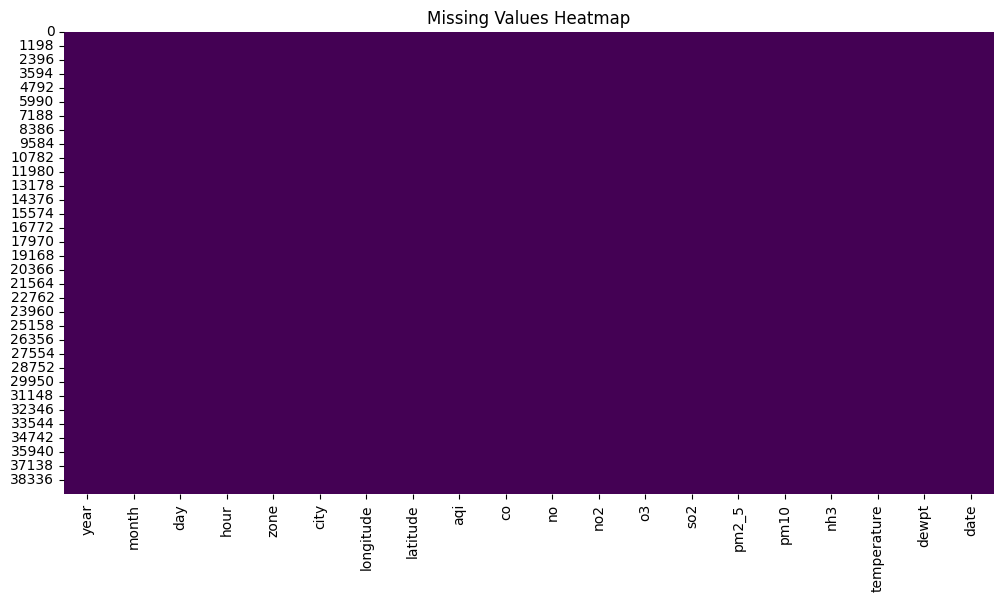

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()


### Histograms of Key Variables

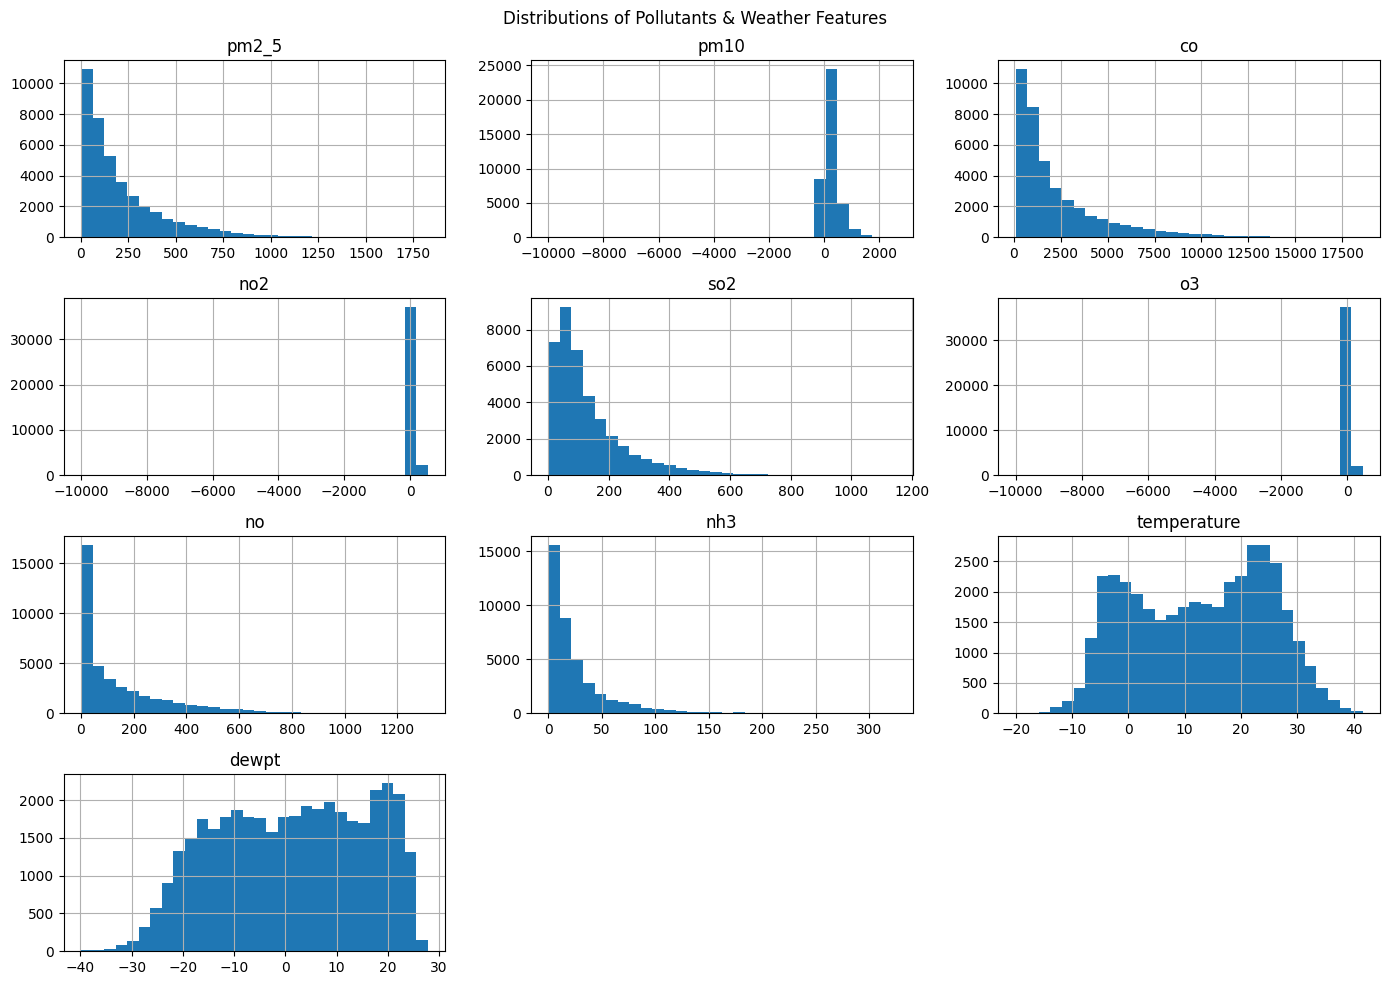

In [3]:
pollutants = ['pm2_5', 'pm10', 'co', 'no2', 'so2', 'o3', 'no', 'nh3']
weather = ['temperature', 'dewpt']

df[pollutants + weather].hist(figsize=(14, 10), bins=30)
plt.suptitle("Distributions of Pollutants & Weather Features")
plt.tight_layout()
plt.show()


### Time Series Plots

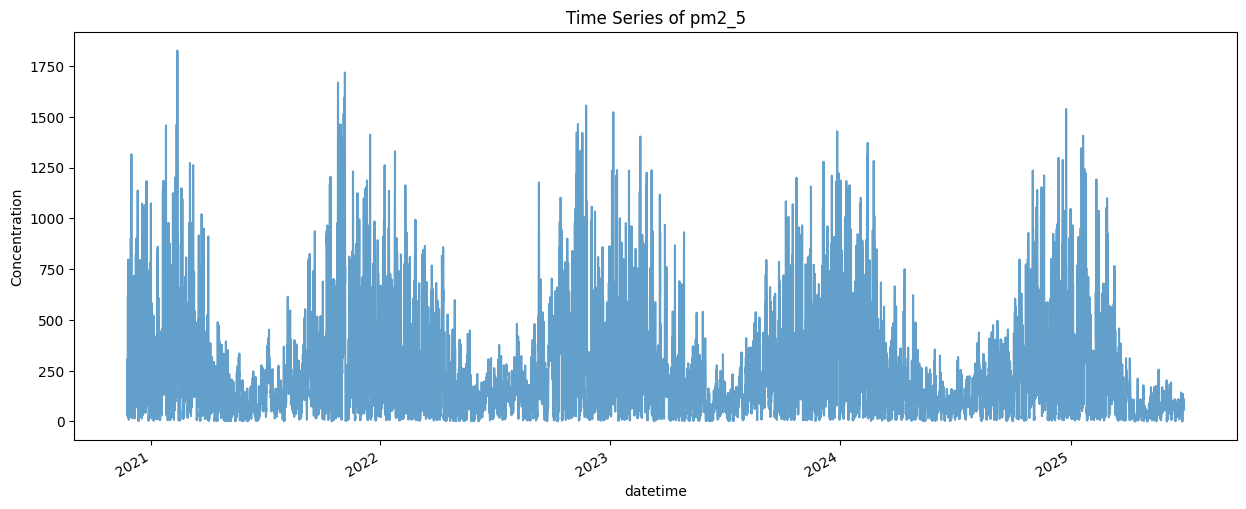

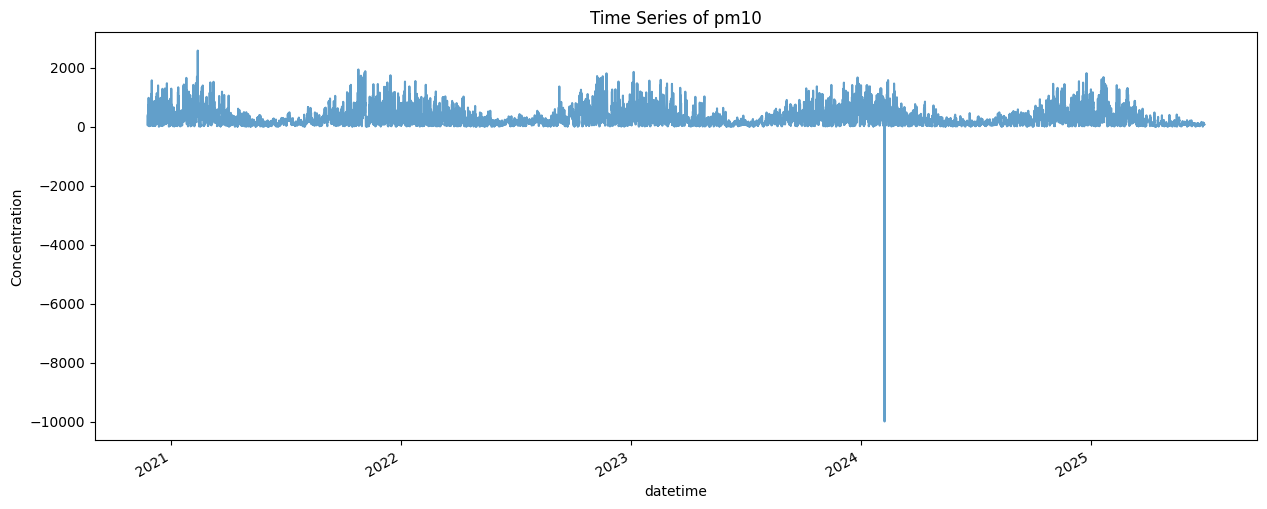

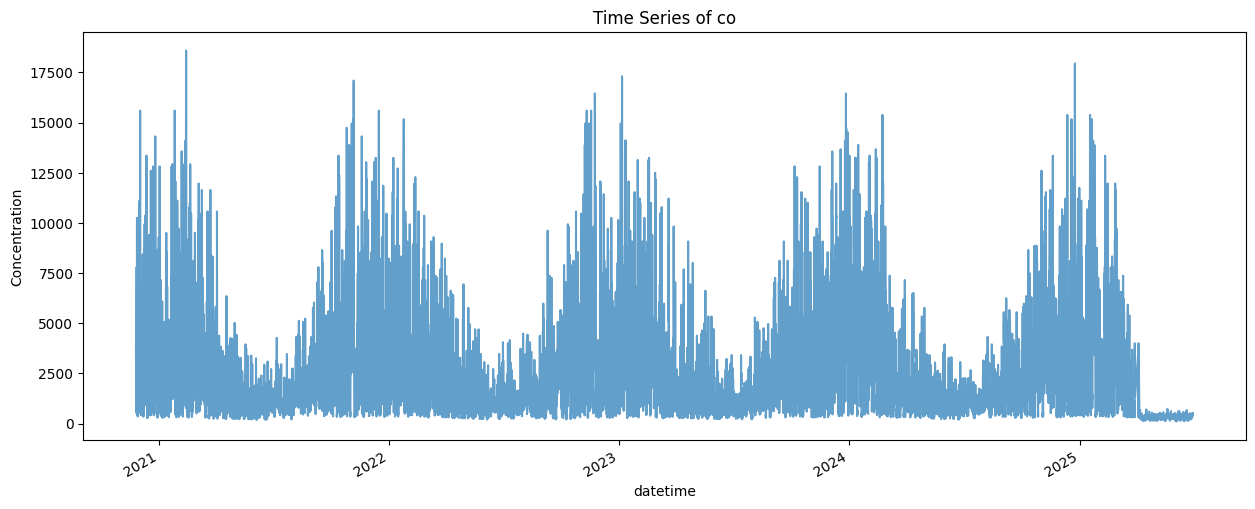

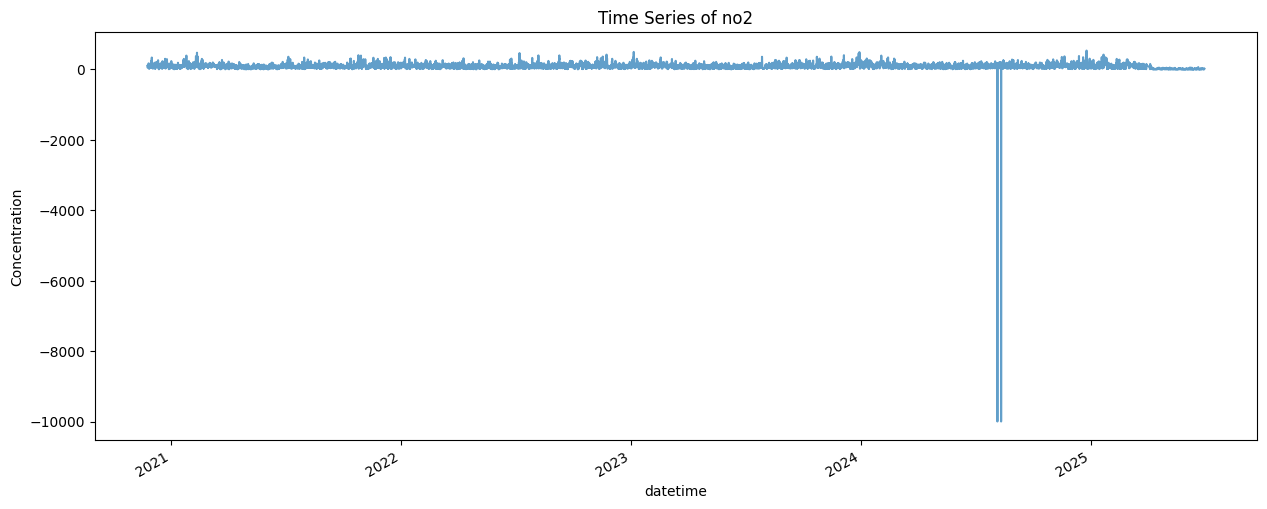

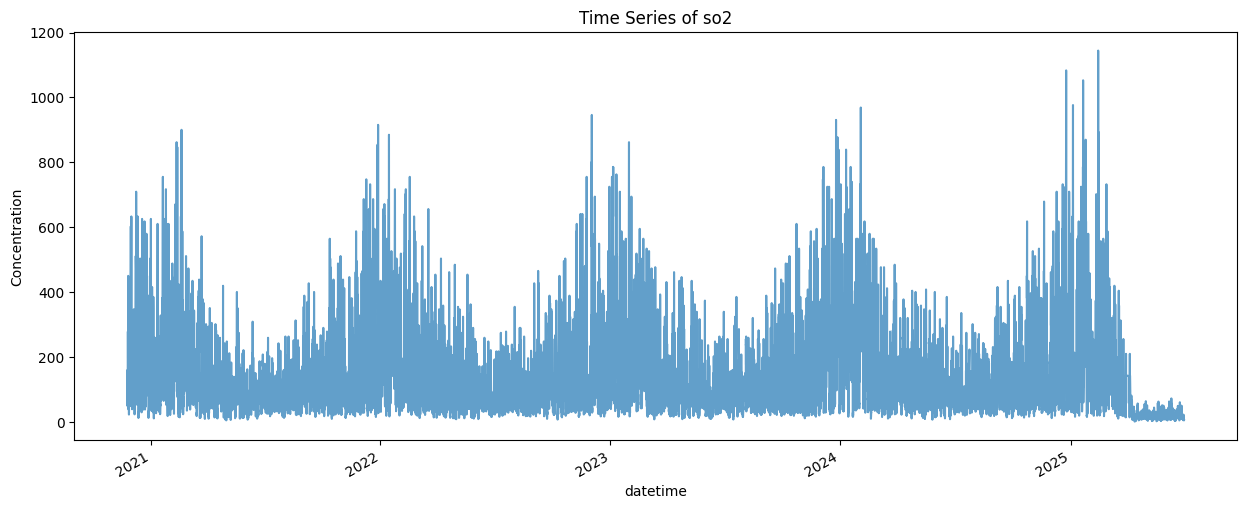

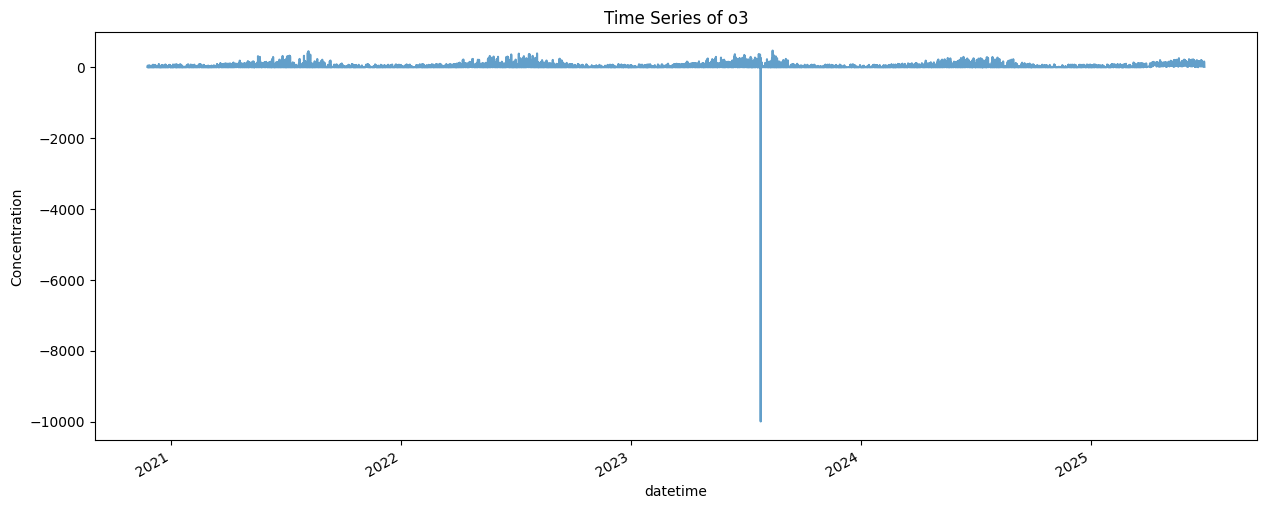

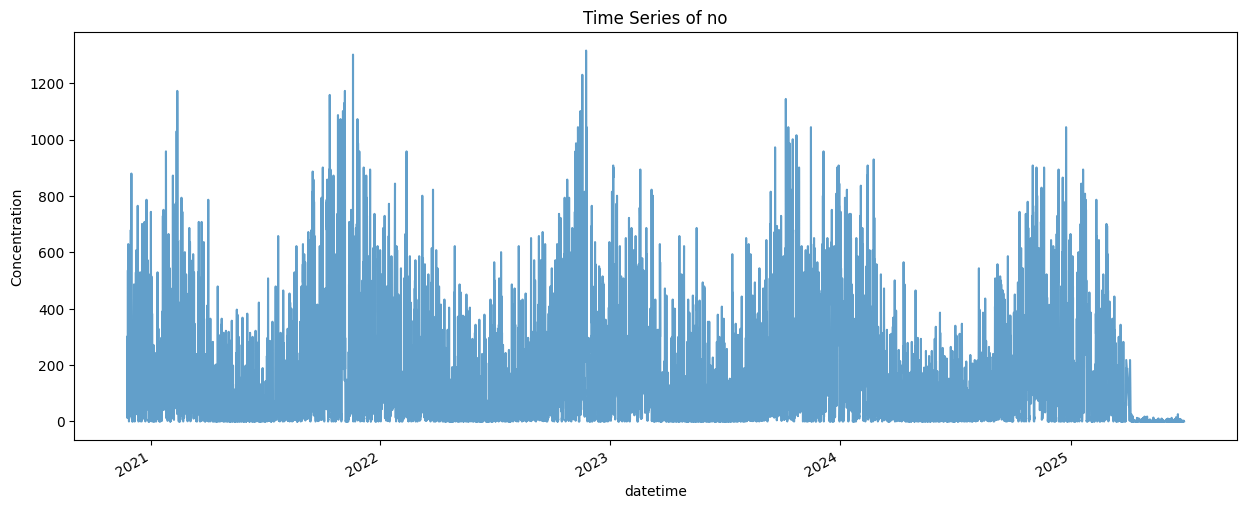

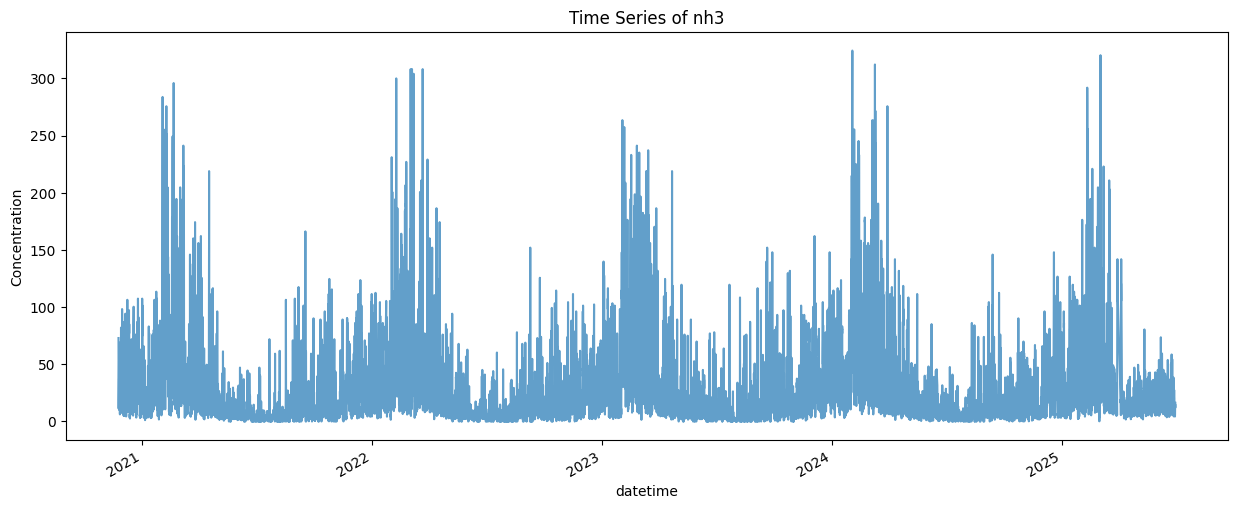

In [4]:
# Parse datetime
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df.set_index('datetime', inplace=True)

for pollutant in pollutants:
# Plot pollutants over time
    df[pollutant].plot(figsize=(15, 6), alpha=0.7)
    plt.title(f"Time Series of {pollutant}")
    plt.ylabel("Concentration")
    plt.show()


### Correlation Heatmap

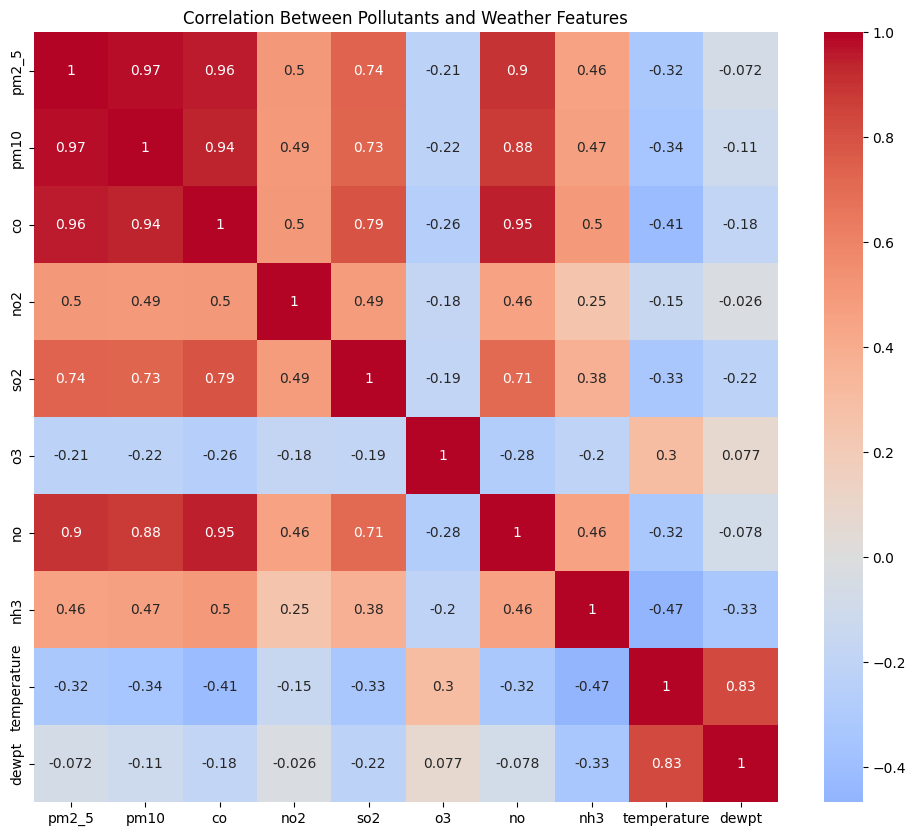

In [5]:
plt.figure(figsize=(12, 10))
corr = df[pollutants + weather].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Between Pollutants and Weather Features")
plt.show()


### Hourly/Daily Patterns

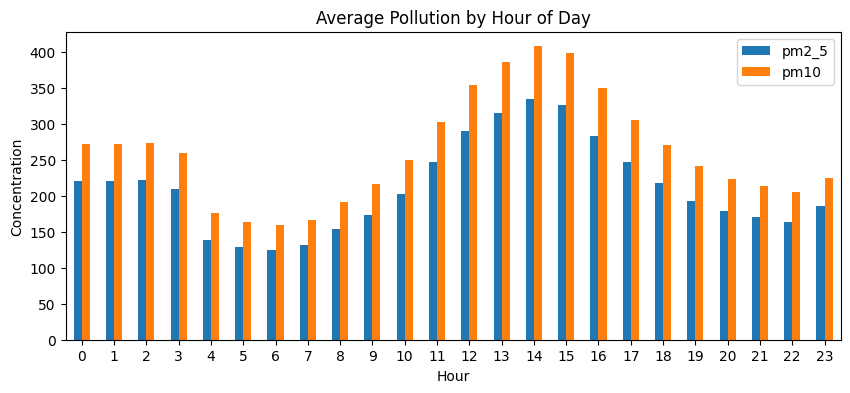

In [6]:
# Hourly average pollution
hourly_avg = df.groupby(df.index.hour)[['pm2_5', 'pm10']].mean()

hourly_avg.plot(kind='bar', figsize=(10, 4))
plt.title("Average Pollution by Hour of Day")
plt.ylabel("Concentration")
plt.xlabel("Hour")
plt.xticks(rotation=0)
plt.show()


# Phase 1: Data Preparation

### Load Data & Parse Datetime

In [22]:
# Load CSV
df = pd.read_csv("./data/beijing.csv")

# Combine year, month, day, hour into datetime
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])

# Set datetime as index
df.set_index('datetime', inplace=True)

# Drop any redundant columns if desired
df.drop(columns=['year', 'month', 'day', 'hour', 'zone', 'city', 'longitude', 'latitude', 'date', 'aqi'], inplace=True)

# Sort by datetime
df = df.sort_index()

df.tail()


,co,no,no2,o3,so2,pm2_5,pm10,nh3,temperature,dewpt
datetime,,,,,,,,,,
2025-06-29 15:00:00,474.83,0.00,17.00,43.27,6.21,62.06,69.47,13.76,23.0,21.9
2025-06-29 16:00:00,480.46,0.00,17.84,31.00,5.06,62.20,69.60,12.63,22.6,21.8
2025-06-29 17:00:00,489.43,0.01,18.80,22.09,4.75,62.34,69.32,12.17,22.5,21.6
2025-06-29 18:00:00,500.19,0.02,20.09,15.62,4.99,63.12,69.68,12.01,22.3,21.5
2025-06-29 19:00:00,510.52,0.06,22.01,10.96,6.04,64.31,70.41,16.37,22.2,21.5


### Outlier Handling

In [23]:
from scipy.stats import zscore

# Z-score outlier removal for numeric columns
z_scores = df.apply(zscore)
df = df[(z_scores < 3).all(axis=1)]  # Keep only within 3 std dev

df.shape


(36830, 10)

### Cleanup and Scaling

In [24]:
# Standardize features
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Ready for modeling
df.to_csv("./data/beijing_preprocessed_unscaled.csv")


### Data Splitting

In [32]:
df = pd.read_csv("./data/beijing_preprocessed_unscaled.csv", parse_dates=['datetime'])

test_hours = 24 * 7
df_train_val = df.iloc[:-test_hours].reset_index(drop=True)
df_test  = df.iloc[-test_hours:].reset_index(drop=True)

# 1) How many validation rows?
n_total = len(df)
n_val   = int(n_total * 0.1)        # 10% of df_train_val
n_train = n_total - n_val          # the rest

# 2) Slice
df_train = df_train_val.iloc[:n_train].reset_index(drop=True)
df_val  = df_train_val.iloc[n_train:].reset_index(drop=True)

# 3) Sanity check
print("Total:",      n_total)
print("Train rows:", len(df_train))
print("Val rows:  ", len(df_val))
print("Test rows:  ", len(df_test))
print("Sum check:", len(df_train) + len(df_val) + len(df_test))


Total: 36830
Train rows: 33147
Val rows:   3515
Test rows:   168
Sum check: 36830


# Phase 2: Feature Selection

### Mutual Information (MI)

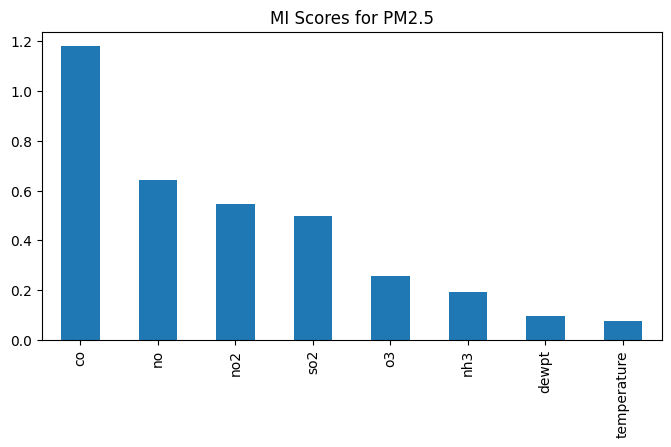

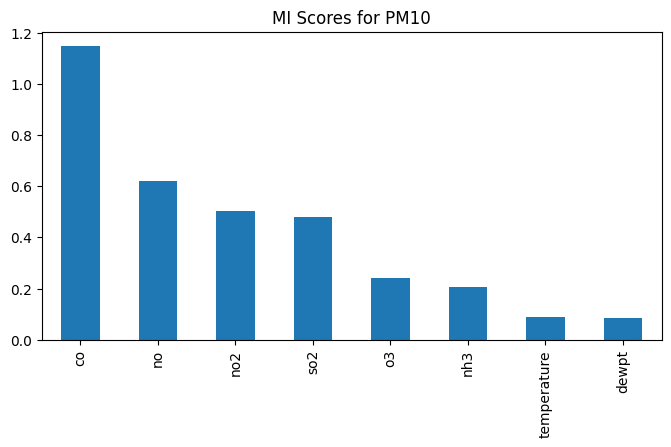

In [33]:
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
import pandas as pd

# Load preprocessed dataset
#df = pd.read_csv("./data/beijing_preprocessed_unscaled.csv", parse_dates=['datetime'])
df = df_train
df.set_index('datetime', inplace=True)

features = ['co', 'no', 'no2', 'o3', 'so2', 'nh3', 'temperature', 'dewpt']

X = df[features]
y_pm25 = df['pm2_5']
y_pm10 = df['pm10']

# Mutual Information for PM2.5
mi_pm25 = mutual_info_regression(X, y_pm25)
mi_scores_pm25 = pd.Series(mi_pm25, index=features).sort_values(ascending=False)

# Mutual Information for PM10
mi_pm10 = mutual_info_regression(X, y_pm10)
mi_scores_pm10 = pd.Series(mi_pm10, index=features).sort_values(ascending=False)

# Plot
mi_scores_pm25.plot(kind='bar', title="MI Scores for PM2.5", figsize=(8, 4))
plt.show()

mi_scores_pm10.plot(kind='bar', title="MI Scores for PM10", figsize=(8, 4))
plt.show()


### mRMR (Minimum Redundancy Maximum Relevance)

In [34]:
import pymrmr

# pymrmr requires all numerical data and no NaNs
df_mrmr = df[features + ['pm2_5', 'pm10']].dropna()
df_mrmr = df_mrmr.reset_index(drop=True)

# mRMR for PM2.5 (returns top 5 features)
mrmr_pm25 = pymrmr.mRMR(df_mrmr.rename(columns={'pm2_5': 'target'}), 'MIQ', 5)

# mRMR for PM10
mrmr_pm10 = pymrmr.mRMR(df_mrmr.rename(columns={'pm10': 'target'}), 'MIQ', 5)

print("Top mRMR Features for PM2.5:", mrmr_pm25)
print("Top mRMR Features for PM10:", mrmr_pm10)




 *** This program and the respective minimum Redundancy Maximum Relevance (mRMR) 
     algorithm were developed by Hanchuan Peng <hanchuan.peng@gmail.com>for
     the paper 
     "Feature selection based on mutual information: criteria of 
      max-dependency, max-relevance, and min-redundancy,"
      Hanchuan Peng, Fuhui Long, and Chris Ding, 
      IEEE Transactions on Pattern Analysis and Machine Intelligence,
      Vol. 27, No. 8, pp.1226-1238, 2005.


*** MaxRel features ***
Order 	 Fea 	 Name 	 Score
1 	 9 	 pm10 	 3.195
2 	 8 	 target 	 3.053
3 	 1 	 no 	 2.194
4 	 4 	 so2 	 1.854
5 	 2 	 no2 	 1.684

*** mRMR features *** 
Order 	 Fea 	 Name 	 Score
1 	 9 	 pm10 	 3.195
2 	 3 	 o3 	 0.941
3 	 1 	 no 	 1.214
4 	 2 	 no2 	 1.215
5 	 8 	 target 	 1.190


 *** This program and the respective minimum Redundancy Maximum Relevance (mRMR) 
     algorithm were developed by Hanchuan Peng <hanchuan.peng@gmail.com>for
     the paper 
     "Feature selection based on mutual information: 

# PHASE 3: Forecasting with NeuralProphet (PM2.5 Target)

### Prepare Data

In [116]:
# Load and format data

df = pd.read_csv("./data/beijing_preprocessed_unscaled.csv", parse_dates=['datetime'])
df = df.drop_duplicates()

# Select features
features = ['pm2_5', 'pm10', 'no', 'no2', 'co', 'so2']

# Rename columns for NeuralProphet
df = df[['datetime'] + features].rename(columns={'datetime': 'ds', 'pm2_5': 'y'})

test_hours = 24 * 7
df_train_val = df.iloc[:-test_hours].reset_index(drop=True)
df_test  = df.iloc[-test_hours:].reset_index(drop=True)

# 1) How many validation rows?
n_total = len(df)
n_val   = int(n_total * 0.1)        # 10% of df_train_val
n_train = n_total - n_val          # the rest

# 2) Slice
df_train = df_train_val.iloc[:n_train].reset_index(drop=True)
df_val  = df_train_val.iloc[n_train:].reset_index(drop=True)

# 3) Sanity check
print("Total:",      n_total)
print("Train rows:", len(df_train))
print("Val rows:  ", len(df_val))
print("Test rows:  ", len(df_test))
print("Sum check:", len(df_train) + len(df_val) + len(df_test))


Total: 36830
Train rows: 33147
Val rows:   3515
Test rows:   168
Sum check: 36830


In [117]:
from sklearn.preprocessing import StandardScaler


# Identify feature columns to scale
feature_cols = [col for col in df_train.columns if col not in ['ds', 'y']]

# Initialize and fit the scaler
scaler = StandardScaler()
df_train[feature_cols] = scaler.fit_transform(df_train[feature_cols])

# Scale df_val
df_val[feature_cols] = scaler.transform(df_val[feature_cols])

# Scale df_test
df_test[feature_cols] = scaler.transform(df_test[feature_cols])


### Initial training to determine autoregression lags

In [45]:
from neuralprophet import NeuralProphet, set_log_level

set_log_level("ERROR")

# Define regressors upfront
regressors = ['pm10', 'no', 'no2', 'co', 'so2']

# Declare model with regressors
model = NeuralProphet(
    #learning_rate=1e-3,
    impute_missing=True,
    #drop_missing=True,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
)

model.set_plotting_backend("matplotlib")

model.add_lagged_regressor(regressors, n_lags=7)

# Fit the model
metrics = model.fit(df, freq='H')

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():



WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1173: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  aux_ts = pd.DataFrame(pd.date_range("1994-01-01", periods=100, freq=freq_str))

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Ser

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/264 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 87. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.



In [46]:
metrics.tail(1)

,train_loss,reg_loss,MAE,RMSE,Loss,RegLoss,epoch
39,0.008889,0.0,29.332285,50.249088,0.008888,0.0,39


WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1173: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  aux_ts = pd.DataFrame(pd.date_range("1994-01-01", periods=100, freq=freq_str))



WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils

Predicting: |          | 0/? [00:00<?, ?it/s]

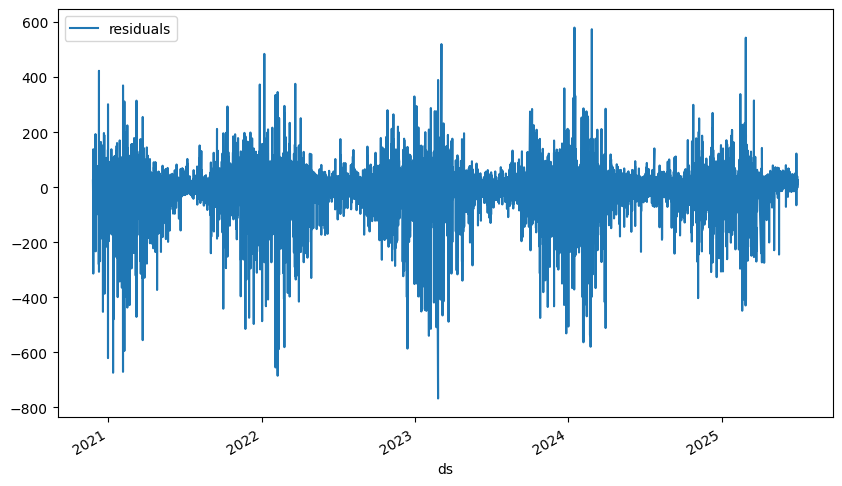

In [47]:
forecast = model.predict(df)
df_residuals = pd.DataFrame({"ds": df["ds"], "residuals": df["y"] - forecast["yhat1"]})
fig = df_residuals.plot(x="ds", y="residuals", figsize=(10, 6))

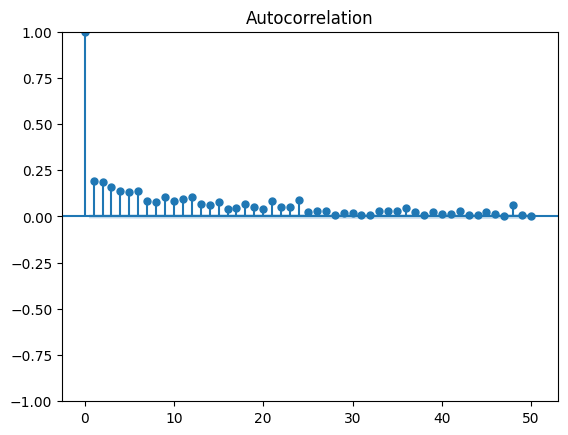

In [48]:
from statsmodels.graphics.tsaplots import plot_acf

plt = plot_acf(df_residuals["residuals"].dropna(), lags=50)

### Final Model Forecasting

In [91]:
from neuralprophet import NeuralProphet, set_log_level

set_log_level("ERROR")

# Define regressors upfront
regressors = ['pm10', 'no', 'no2', 'co', 'so2']

# Declare model with regressors
pm2_5_model_np = NeuralProphet(
    #learning_rate=1e-3,
    impute_missing=True,
    #drop_missing=True,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    #n_lags=5
)


In [92]:
pm2_5_model_np.set_plotting_backend("matplotlib")

pm2_5_model_np.add_lagged_regressor(regressors, n_lags=7)

# Fit the model
metrics = pm2_5_model_np.fit(df_train, validation_df=df_val, freq='H', epochs=50)

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/263 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [93]:
metrics.tail(1)

,MAE_val,RMSE_val,Loss_val,RegLoss_val,epoch,train_loss,reg_loss,MAE,RMSE,Loss,RegLoss
49,23.751659,41.638508,0.010429,0.0,49,0.00933,0.0,29.33359,52.050648,0.009331,0.0


WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1173: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  aux_ts = pd.DataFrame(pd.date_range("1994-01-01", periods=100, freq=freq_str))

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Ser

Predicting: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/plot_forecast_matplotlib.py:84: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ds = fcst["ds"].dt.to_pydatetime()



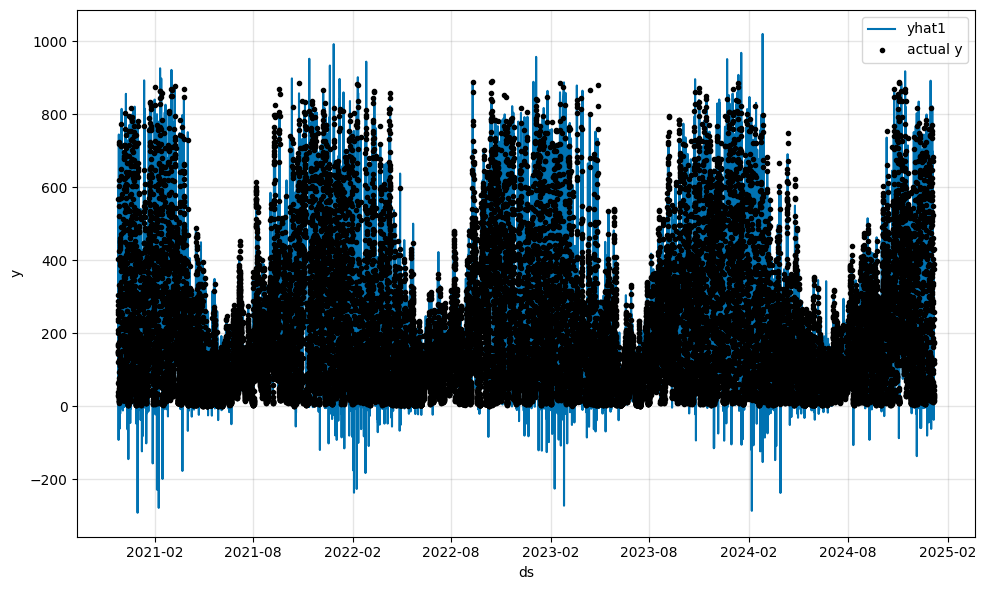

In [94]:
forecast = pm2_5_model_np.predict(df_train)
pm2_5_model_np.plot(forecast)

### Test Results

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1173: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  aux_ts = pd.DataFrame(pd.date_range("1994-01-01", periods=100, freq=freq_str))

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Ser

Predicting: |          | 0/? [00:00<?, ?it/s]

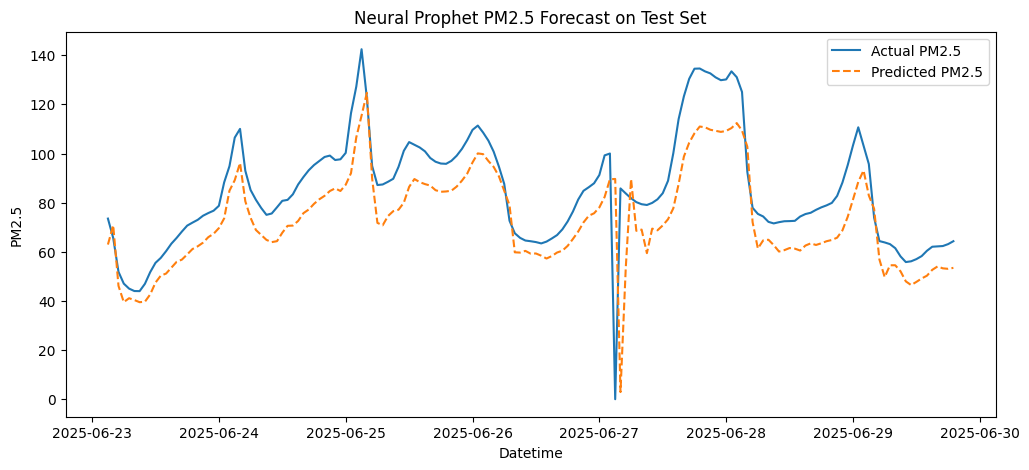

In [118]:
import matplotlib.pyplot as plt

# 1) Predict on the test set
forecast_test = pm2_5_model_np.predict(df_test)

# 2) Build two Series indexed by ds
pred = forecast_test.set_index('ds')['yhat1']
actual = df_test.set_index('ds')['y']

# 3) Align by joining on ds (inner join drops any extra/missing timestamps)
cmp_test = actual.to_frame('y').join(pred.to_frame('yhat1'), how='inner').dropna()

# 4) Plot Actual vs Predicted
plt.figure(figsize=(12,5))
plt.plot(cmp_test.index, cmp_test['y'],    label='Actual PM2.5')
plt.plot(cmp_test.index, cmp_test['yhat1'], label='Predicted PM2.5', linestyle='--')
plt.title("Neural Prophet PM2.5 Forecast on Test Set")
plt.xlabel("Datetime")
plt.ylabel("PM2.5")
plt.legend()
plt.show()


In [96]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

# 5) Compute metrics
y_true = cmp_test['y']
y_pred = cmp_test['yhat1']

mae_np_pm2_5_test  = mean_absolute_error(y_true, y_pred)
rmse_np_pm2_5_test = root_mean_squared_error(y_true, y_pred)
r2_np_pm2_5_test   = r2_score(y_true, y_pred)

print(f"Neural Prophet PM2.5 Forecasting Test MAE:  {mae_np_pm2_5_test:.3f}")
print(f"Neural Prophet PM2.5 Forecasting Train RMSE: {rmse_np_pm2_5_test:.3f}")
print(f"Neural Prophet PM2.5 Forecasting Test R²:   {r2_np_pm2_5_test:.3f}")

Neural Prophet PM2.5 Forecasting Test MAE:  13.400
Neural Prophet PM2.5 Forecasting Train RMSE: 16.621
Neural Prophet PM2.5 Forecasting Test R²:   0.457


# PHASE 4: Forecasting with NeuralProphet (PM10 Target)

### Prepare Data

In [98]:
# Load and format data

df = pd.read_csv("./data/beijing_preprocessed_unscaled.csv", parse_dates=['datetime'])
df = df.drop_duplicates()

# Select features
features = ['pm2_5', 'pm10', 'no', 'no2', 'co', 'so2']

# Rename columns for NeuralProphet
df = df[['datetime'] + features].rename(columns={'datetime': 'ds', 'pm10': 'y'})

test_hours = 24 * 7
df_train_val = df.iloc[:-test_hours].reset_index(drop=True)
df_test  = df.iloc[-test_hours:].reset_index(drop=True)

# 1) How many validation rows?
n_total = len(df)
n_val   = int(n_total * 0.1)        # 10% of df_train_val
n_train = n_total - n_val          # the rest

# 2) Slice
df_train = df_train_val.iloc[:n_train].reset_index(drop=True)
df_val  = df_train_val.iloc[n_train:].reset_index(drop=True)

# 3) Sanity check
print("Total:",      n_total)
print("Train rows:", len(df_train))
print("Val rows:  ", len(df_val))
print("Test rows:  ", len(df_test))
print("Sum check:", len(df_train) + len(df_val) + len(df_test))

Total: 36830
Train rows: 33147
Val rows:   3515
Test rows:   168
Sum check: 36830


In [99]:
from sklearn.preprocessing import StandardScaler


# Identify feature columns to scale
feature_cols = [col for col in df_train.columns if col not in ['ds', 'y']]

# Initialize and fit the scaler
scaler = StandardScaler()
df_train[feature_cols] = scaler.fit_transform(df_train[feature_cols])

# Scale df_val
df_val[feature_cols] = scaler.transform(df_val[feature_cols])

# Scale df_test
df_test[feature_cols] = scaler.transform(df_test[feature_cols])

### Final Model Forecasting

In [102]:
from neuralprophet import NeuralProphet, set_log_level

set_log_level("ERROR")

# Define regressors upfront
regressors = ['pm2_5','no', 'no2', 'co', 'so2']

# Declare model with regressors
pm10_model_np = NeuralProphet(
    #learning_rate=1e-3,
    impute_missing=True,
    #drop_missing=True,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    #n_lags=5
)

In [103]:
pm10_model_np.set_plotting_backend("matplotlib")

pm10_model_np.add_lagged_regressor(regressors, n_lags=7)

# Fit the model
metrics = pm10_model_np.fit(df_train, validation_df=df_val, freq='H', epochs=50)

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/263 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [104]:
metrics.tail(1)

,MAE_val,RMSE_val,Loss_val,RegLoss_val,epoch,train_loss,reg_loss,MAE,RMSE,Loss,RegLoss
49,29.568304,50.814842,0.010613,0.0,49,0.008533,0.0,33.334965,60.429848,0.008533,0.0


WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1173: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  aux_ts = pd.DataFrame(pd.date_range("1994-01-01", periods=100, freq=freq_str))



WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils

Predicting: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/plot_forecast_matplotlib.py:84: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ds = fcst["ds"].dt.to_pydatetime()



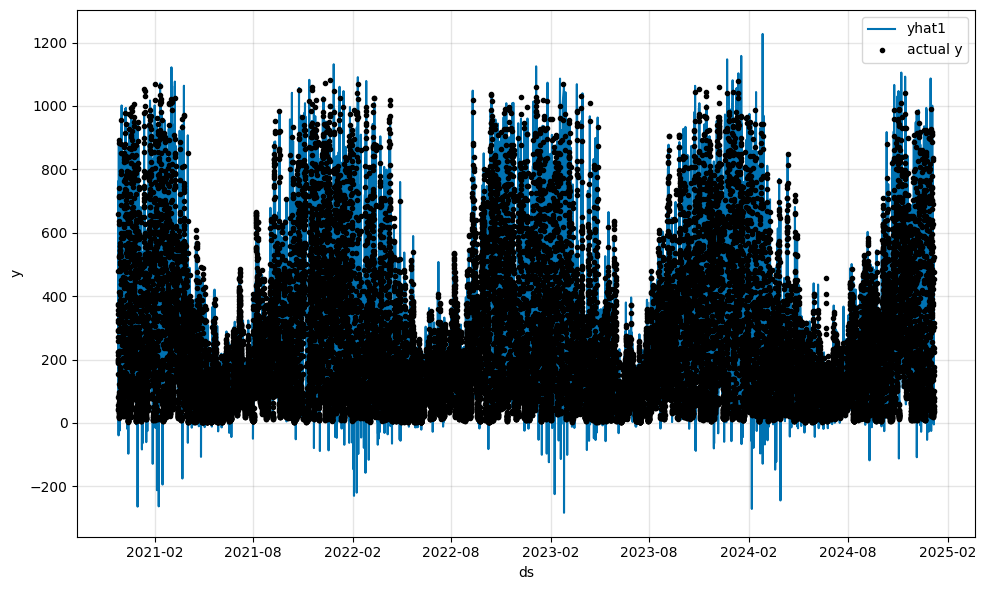

In [58]:
forecast = pm10_model_np.predict(df_train)
pm10_model_np.plot(forecast)

### Test Results

#### Prediction on 168 hours

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1173: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  aux_ts = pd.DataFrame(pd.date_range("1994-01-01", periods=100, freq=freq_str))

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Ser

Predicting: |          | 0/? [00:00<?, ?it/s]

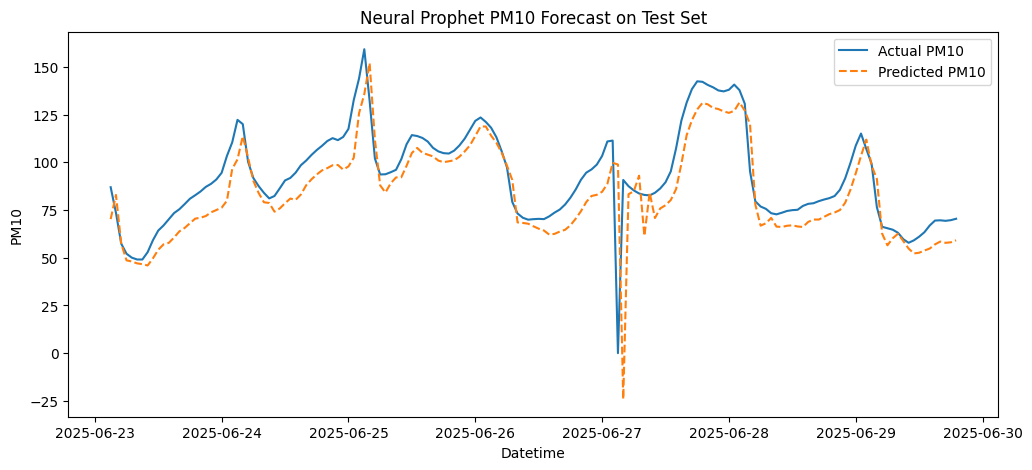

In [109]:
import matplotlib.pyplot as plt

# 1) Predict on the test set
forecast_test = pm10_model_np.predict(df_test)

# 2) Build two Series indexed by ds
pred = forecast_test.set_index('ds')['yhat1']
actual = df_test.set_index('ds')['y']

# 3) Align by joining on ds (inner join drops any extra/missing timestamps)
cmp_test = actual.to_frame('y').join(pred.to_frame('yhat1'), how='inner').dropna()

# 4) Plot Actual vs Predicted
plt.figure(figsize=(12,5))
plt.plot(cmp_test.index, cmp_test['y'],    label='Actual PM10')
plt.plot(cmp_test.index, cmp_test['yhat1'], label='Predicted PM10', linestyle='--')
plt.title("Neural Prophet PM10 Forecast on Test Set")
plt.xlabel("Datetime")
plt.ylabel("PM10")
plt.legend()
plt.show()


In [110]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

# 5) Compute metrics
y_true = cmp_test['y']
y_pred = cmp_test['yhat1']

mae_np_pm10_test  = mean_absolute_error(y_true, y_pred)
rmse_np_pm10_test = root_mean_squared_error(y_true, y_pred)
r2_np_pm10_test   = r2_score(y_true, y_pred)

print(f"Neural Prophet PM10 Forecasting Test MAE:  {mae_np_pm10_test:.3f}")
print(f"Neural Prophet PM10 Forecasting Test RMSE: {rmse_np_pm10_test:.3f}")
print(f"Neural Prophet PM10 Forecasting Test R²:   {r2_np_pm10_test:.3f}")

Neural Prophet PM10 Forecasting Test MAE:  11.223
Neural Prophet PM10 Forecasting Test RMSE: 16.553
Neural Prophet PM10 Forecasting Test R²:   0.540


#### Prediction on 24 hours

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1173: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  aux_ts = pd.DataFrame(pd.date_range("1994-01-01", periods=100, freq=freq_str))

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Ser

Predicting: |          | 0/? [00:00<?, ?it/s]

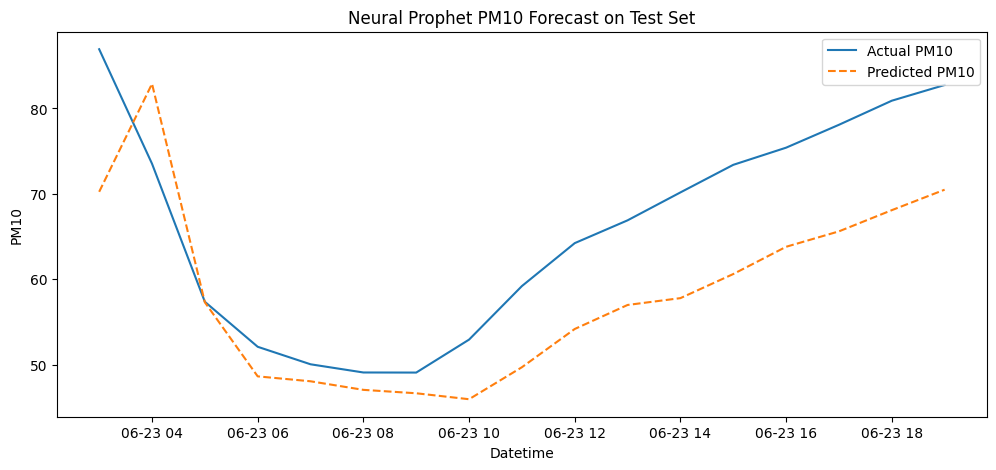

In [113]:
import matplotlib.pyplot as plt

# 1) Predict on the test set
forecast_test = pm10_model_np.predict(df_test[:24])

# 2) Build two Series indexed by ds
pred = forecast_test.set_index('ds')['yhat1']
actual = df_test.set_index('ds')['y']

# 3) Align by joining on ds (inner join drops any extra/missing timestamps)
cmp_test = actual.to_frame('y').join(pred.to_frame('yhat1'), how='inner').dropna()

# 4) Plot Actual vs Predicted
plt.figure(figsize=(12,5))
plt.plot(cmp_test.index, cmp_test['y'],    label='Actual PM10')
plt.plot(cmp_test.index, cmp_test['yhat1'], label='Predicted PM10', linestyle='--')
plt.title("Neural Prophet PM10 Forecast on Test Set")
plt.xlabel("Datetime")
plt.ylabel("PM10")
plt.legend()
plt.show()


In [112]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

# 5) Compute metrics
y_true = cmp_test['y']
y_pred = cmp_test['yhat1']

mae_np_pm10_test  = mean_absolute_error(y_true, y_pred)
rmse_np_pm10_test = root_mean_squared_error(y_true, y_pred)
r2_np_pm10_test   = r2_score(y_true, y_pred)

print(f"Neural Prophet PM10 Forecasting Test MAE:  {mae_np_pm10_test:.3f}")
print(f"Neural Prophet PM10 Forecasting Test RMSE: {rmse_np_pm10_test:.3f}")
print(f"Neural Prophet PM10 Forecasting Test R²:   {r2_np_pm10_test:.3f}")

Neural Prophet PM10 Forecasting Test MAE:  8.637
Neural Prophet PM10 Forecasting Test RMSE: 9.861
Neural Prophet PM10 Forecasting Test R²:   0.369


# FB Prophet (PM2.5 Target)

### Prepare Data

In [ ]:
# Load and format data

df = pd.read_csv("./data/beijing_preprocessed_unscaled.csv", parse_dates=['datetime'])
df = df.drop_duplicates()

# Select features
features = ['pm10', 'pm2_5', 'no', 'no2', 'co', 'so2']

# Rename columns for NeuralProphet
df = df[['datetime'] + features].rename(columns={'datetime': 'ds', 'pm2_5': 'y'})

test_hours = 24 * 7
df_train = df.iloc[:-test_hours].reset_index(drop=True)
df_test  = df.iloc[-test_hours:].reset_index(drop=True)

n_total = len(df)

print("Total:",      n_total)
print("Train rows:", len(df_train))
print("Test rows:  ", len(df_test))
print("Sum check:", len(df_train) + len(df_test))

Total: 36830
Train rows: 36662
Test rows:   168
Sum check: 36830


In [78]:
from sklearn.preprocessing import StandardScaler


# Identify feature columns to scale
feature_cols = [col for col in df_train.columns if col not in ['ds', 'y']]

# Initialize and fit the scaler
scaler = StandardScaler()
df_train[feature_cols] = scaler.fit_transform(df_train[feature_cols])

# Scale df_val
df_val[feature_cols] = scaler.transform(df_val[feature_cols])

# Scale df_test
df_test[feature_cols] = scaler.transform(df_test[feature_cols])

### Model Implementation

In [120]:
from prophet import Prophet

# Define regressors
regressors = ['no', 'no2', 'co', 'so2', 'pm10']

# Initialize model
pm2_5_model_fbp = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

# Add external regressors
for reg in regressors:
    pm2_5_model_fbp.add_regressor(reg)

In [121]:
# Fit the model
pm2_5_model_fbp.fit(df_train)

02:09:16 - cmdstanpy - INFO - Chain [1] start processing
02:09:58 - cmdstanpy - INFO - Chain [1] done processing


### Training Results

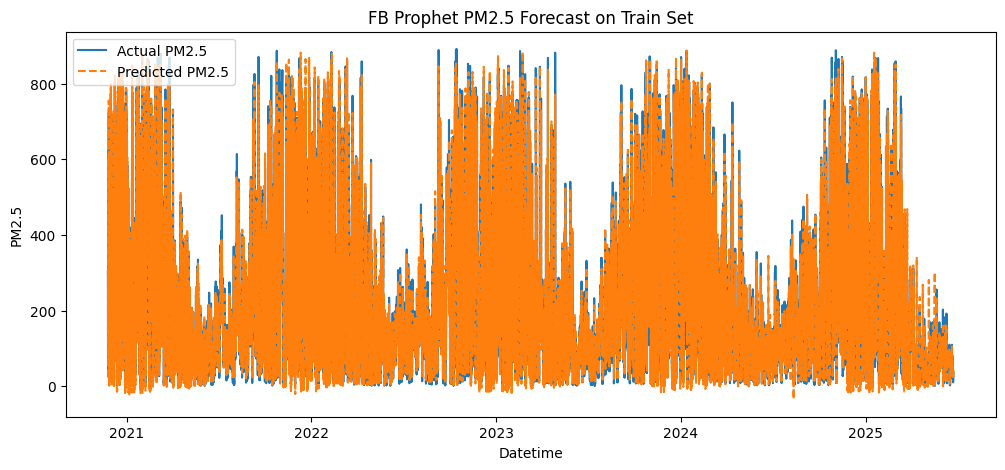

In [122]:
import matplotlib.pyplot as plt

# 1) Predict on the train set
forecast_train = pm2_5_model_fbp.predict(df_train)
#forecast_test.columns

# 2) Build two Series indexed by ds
pred = forecast_train.set_index('ds')['yhat']
actual = df_train.set_index('ds')['y']

# 3) Align by joining on ds (inner join drops any extra/missing timestamps)
cmp_train = actual.to_frame('y').join(pred.to_frame('yhat'), how='inner').dropna()

# 4) Plot Actual vs Predicted
plt.figure(figsize=(12,5))
plt.plot(cmp_train.index, cmp_train['y'],    label='Actual PM2.5')
plt.plot(cmp_train.index, cmp_train['yhat'], label='Predicted PM2.5', linestyle='--')
plt.title("FB Prophet PM2.5 Forecast on Train Set")
plt.xlabel("Datetime")
plt.ylabel("PM2.5")
plt.legend()
plt.show()


In [123]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

# 5) Compute metrics
y_true = cmp_train['y']
y_pred = cmp_train['yhat']

mae_fbp_pm2_5_train  = mean_absolute_error(y_true, y_pred)
rmse_fbp_pm2_5_train = root_mean_squared_error(y_true, y_pred)

print(f"FB-Prophet PM2.5 Forecasting Train MAE:  {mae_fbp_pm2_5_train:.3f}")
print(f"FB-Prophet PM2.5 Forecasting Train RMSE: {rmse_fbp_pm2_5_train:.3f}")

FB-Prophet PM2.5 Forecasting Train MAE:  14.428
FB-Prophet PM2.5 Forecasting Train RMSE: 24.566


### Test Results

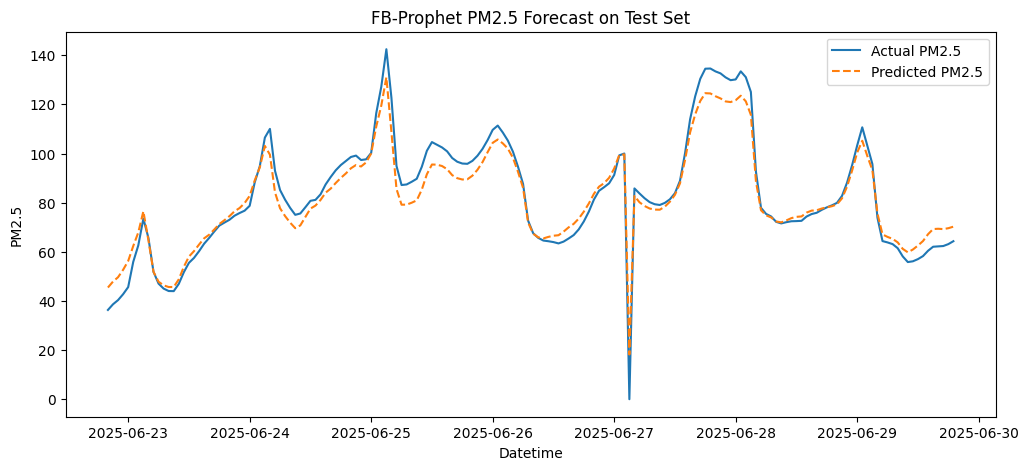

In [125]:
import matplotlib.pyplot as plt

# 1) Predict on the test set
forecast_test = pm2_5_model_fbp.predict(df_test)
#forecast_test.columns

# 2) Build two Series indexed by ds
pred = forecast_test.set_index('ds')['yhat']
actual = df_test.set_index('ds')['y']

# 3) Align by joining on ds (inner join drops any extra/missing timestamps)
cmp_test = actual.to_frame('y').join(pred.to_frame('yhat'), how='inner').dropna()

# 4) Plot Actual vs Predicted
plt.figure(figsize=(12,5))
plt.plot(cmp_test.index, cmp_test['y'],    label='Actual PM2.5')
plt.plot(cmp_test.index, cmp_test['yhat'], label='Predicted PM2.5', linestyle='--')
plt.title("FB-Prophet PM2.5 Forecast on Test Set")
plt.xlabel("Datetime")
plt.ylabel("PM2.5")
plt.legend()
plt.show()


In [126]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

# 5) Compute metrics
y_true = cmp_test['y']
y_pred = cmp_test['yhat']

mae_fbp_pm2_5_test  = mean_absolute_error(y_true, y_pred)
rmse_fbp_pm2_5_test = root_mean_squared_error(y_true, y_pred)
r2_fbp_pm2_5_test   = r2_score(y_true, y_pred)

print(f"FB-Prophet PM2.5 Forecasting Test MAE: {mae_fbp_pm2_5_test:.3f}")
print(f"FB-Prophet PM2.5 Forecasting Test RMSE:{rmse_fbp_pm2_5_test:.3f}")
print(f"FB-Prophet PM2.5 Forecasting Test R²:  {r2_fbp_pm2_5_test:.3f}")

FB-Prophet PM2.5 Forecasting Test MAE: 4.319
FB-Prophet PM2.5 Forecasting Test RMSE:5.449
FB-Prophet PM2.5 Forecasting Test R²:  0.946


# FB Prophet (PM10 Target)

### Prepare Data

In [143]:
# Load and format data

df = pd.read_csv("./data/beijing_preprocessed_unscaled.csv", parse_dates=['datetime'])
df = df.drop_duplicates()

# Select features
features = ['pm10', 'pm2_5', 'no', 'no2', 'co', 'so2']

# Rename columns for NeuralProphet
df = df[['datetime'] + features].rename(columns={'datetime': 'ds', 'pm10': 'y'})

test_hours = 24 * 7
df_train = df.iloc[:-test_hours].reset_index(drop=True)
df_test  = df.iloc[-test_hours:].reset_index(drop=True)

n_total = len(df)

print("Total:",      n_total)
print("Train rows:", len(df_train))
print("Test rows:  ", len(df_test))
print("Sum check:", len(df_train) + len(df_test))

Total: 36830
Train rows: 36662
Test rows:   168
Sum check: 36830


In [136]:
from sklearn.preprocessing import StandardScaler


# Identify feature columns to scale
feature_cols = [col for col in df_train.columns if col not in ['ds', 'y']]

# Initialize and fit the scaler
scaler = StandardScaler()
df_train[feature_cols] = scaler.fit_transform(df_train[feature_cols])

# Scale df_test
df_test[feature_cols] = scaler.transform(df_test[feature_cols])

### Model Implemetation

In [145]:
from prophet import Prophet

# Define regressors
regressors = ['no', 'no2', 'co', 'so2', 'pm2_5']

# Initialize model
pm10_model_fbp = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

# Add external regressors
for reg in regressors:
    pm10_model_fbp.add_regressor(reg)

In [146]:
# Fit the model
pm10_model_fbp.fit(df_train)

02:25:03 - cmdstanpy - INFO - Chain [1] start processing
02:25:28 - cmdstanpy - INFO - Chain [1] done processing


### Training Results

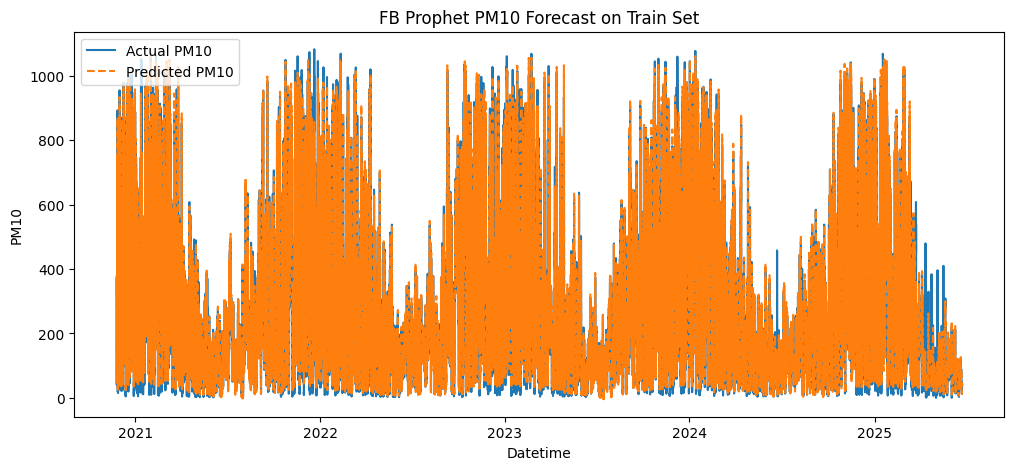

In [147]:
import matplotlib.pyplot as plt

# 1) Predict on the train set
forecast_train = pm10_model_fbp.predict(df_train)
#forecast_test.columns

# 2) Build two Series indexed by ds
pred = forecast_train.set_index('ds')['yhat']
actual = df_train.set_index('ds')['y']

# 3) Align by joining on ds (inner join drops any extra/missing timestamps)
cmp_train = actual.to_frame('y').join(pred.to_frame('yhat'), how='inner').dropna()

# 4) Plot Actual vs Predicted
plt.figure(figsize=(12,5))
plt.plot(cmp_train.index, cmp_train['y'],    label='Actual PM10')
plt.plot(cmp_train.index, cmp_train['yhat'], label='Predicted PM10', linestyle='--')
plt.title("FB Prophet PM10 Forecast on Train Set")
plt.xlabel("Datetime")
plt.ylabel("PM10")
plt.legend()
plt.show()


In [149]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

# 5) Compute metrics
y_true = cmp_train['y']
y_pred = cmp_train['yhat']

mae_fbp_pm10_train  = mean_absolute_error(y_true, y_pred)
rmse_fbp_pm10_train = root_mean_squared_error(y_true, y_pred)

print(f"FB-Prophet PM10 Forecasting Train MAE:  {mae_fbp_pm10_train:.3f}")
print(f"FB-Prophet PM10 Forecasting Train RMSE: {rmse_fbp_pm10_train:.3f}")

FB-Prophet PM10 Forecasting Train MAE:  14.506
FB-Prophet PM10 Forecasting Train RMSE: 30.290


### Test Results

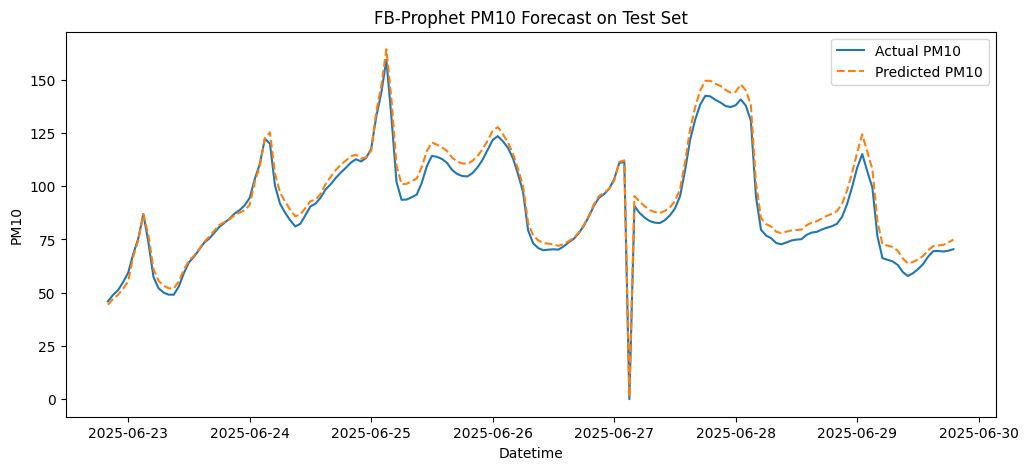

In [148]:
import matplotlib.pyplot as plt

# 1) Predict on the test set
forecast_test = pm10_model_fbp.predict(df_test)
#forecast_test.columns

# 2) Build two Series indexed by ds
pred = forecast_test.set_index('ds')['yhat']
actual = df_test.set_index('ds')['y']

# 3) Align by joining on ds (inner join drops any extra/missing timestamps)
cmp_test = actual.to_frame('y').join(pred.to_frame('yhat'), how='inner').dropna()

# 4) Plot Actual vs Predicted
plt.figure(figsize=(12,5))
plt.plot(cmp_test.index, cmp_test['y'],    label='Actual PM10')
plt.plot(cmp_test.index, cmp_test['yhat'], label='Predicted PM10', linestyle='--')
plt.title("FB-Prophet PM10 Forecast on Test Set")
plt.xlabel("Datetime")
plt.ylabel("PM10")
plt.legend()
plt.show()


In [150]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

# 5) Compute metrics
y_true = cmp_test['y']
y_pred = cmp_test['yhat']

mae_fbp_pm10_test  = mean_absolute_error(y_true, y_pred)
rmse_fbp_pm10_test = root_mean_squared_error(y_true, y_pred)
r2_fbp_pm10_test   = r2_score(y_true, y_pred)

print(f"FB-Prophet PM10 Forecasting Test MAE: {mae_fbp_pm10_test:.3f}")
print(f"FB-Prophet PM10 Forecasting Test RMSE:{rmse_fbp_pm10_test:.3f}")
print(f"FB-Prophet PM10 Forecasting Test R²:  {r2_fbp_pm10_test:.3f}")

FB-Prophet PM10 Forecasting Test MAE: 4.002
FB-Prophet PM10 Forecasting Test RMSE:4.633
FB-Prophet PM10 Forecasting Test R²:  0.966
